In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import recall_score, precision_score, classification_report, confusion_matrix,ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

from xgboost import XGBClassifier


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [3]:
# Import telemetry data
df_raw = pd.read_csv('./data/telemetry.csv')

df_raw['datetime'] = pd.to_datetime(df_raw['datetime'], format='%m/%d/%Y %I:%M:%S %p')

df_raw.head()

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511


In [4]:
print("List of machineID: {}".format(df_raw['machineID'].unique()))

List of machineID: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100]


In [5]:
# Check for correlation between tags
df_raw.iloc[:, 2:].corr()

,volt,rotate,pressure,vibration
volt,1.000000,-0.001511,0.001652,0.002390
rotate,-0.001511,1.000000,-0.000688,-0.003056
pressure,0.001652,-0.000688,1.000000,0.001395
vibration,0.002390,-0.003056,0.001395,1.000000


In [6]:
cols = df_raw.columns[2:].to_list()

df_mean = df_raw.groupby('machineID').resample('D', on='datetime').mean().\
    drop(columns='machineID').rename(columns={c: c + '_mean' for c in cols})

df_std = df_raw.groupby('machineID').resample('D', on='datetime').std().\
    drop(columns='machineID').rename(columns={c: c + '_std' for c in cols})

df_agg = df_mean.merge(df_std, how='inner', left_index=True, right_index=True)

# Convert datetime index to date
df_agg.reset_index(inplace=True)
df_agg['datetime'] = df_agg['datetime'].dt.date
df_agg.set_index(['machineID', 'datetime'], inplace=True)

df_agg

volt_mean  rotate_mean  pressure_mean  vibration_mean  \
machineID datetime                                                             
1         2015-01-01  167.576533   440.515328      98.522345       40.049623   
          2015-01-02  169.795758   446.832666      98.454608       39.271645   
          2015-01-03  171.862244   459.204742      97.998233       48.074091   
          2015-01-04  174.792428   448.743201     101.452266       52.190268   
          2015-01-05  171.018408   454.822750     102.363114       43.330311   
...                          ...          ...            ...             ...   
100       2015-12-28  170.982029   454.875385      97.864404       39.221774   
          2015-12-29  167.114444   459.097599      97.531682       40.117173   
          2015-12-30  168.613777   455.140822      98.415400       39.995452   
          2015-12-31  168.469994   463.241909     101.846119       38.826901   
          2016-01-01  175.690455   445.693412      97.504105       44.080262   

                       volt_std  rotate_std  pressure_std  vibration_std  
machineID datetime                                                        
1         2015-01-01   9.300337   49.590263     10.588562       5.739395  
          2015-01-02  15.742155   38.800266     11.679314       5.579524  
          2015-01-03  11.182853   47.387959      8.884765       8.194927  
          2015-01-04  19.224657   34.008026     10.807630       5.081258  
          2015-01-05  17.900560   47.803621     10.672868       8.087134  
...                         ...         ...           ...            ...  
100       2015-12-28  15.030665   58.013495      8.522116       5.384053  
          2015-12-29  16.654803   56.447064      9.257888       4.916935  
          2015-12-30  12.261241   59.849202      9.359740       4.896418  
          2015-12-31  17.310060   67.148361      9.567172       5.670301  
          2016-01-01  11.756392   35.153622      8.808406       5.668216  

[36600 rows x 8 columns]

In [8]:
# Import machines data
df_machine = pd.read_csv('./data/machines.csv')

df_machine.head()

,machineID,model,age
0,1,model3,18
1,2,model4,7
2,3,model3,8
3,4,model3,7
4,5,model3,2


In [12]:
# Import maintenance data
df_maint = pd.read_csv('./data/maint.csv')

df_maint.head()

,datetime,machineID,comp
0,6/1/2014 6:00:00 AM,1,comp2
1,7/16/2014 6:00:00 AM,1,comp4
2,7/31/2014 6:00:00 AM,1,comp3
3,12/13/2014 6:00:00 AM,1,comp1
4,1/5/2015 6:00:00 AM,1,comp4


In [13]:
# Prepare df_maint
df_maint = pd.read_csv('./data/maint.csv')

df_maint['datetime'] = pd.to_datetime(df_maint['datetime'], format='%m/%d/%Y %I:%M:%S %p')
df_maint['datetime'] = df_maint['datetime'].dt.date
df_maint['value'] = 1

df_maint = pd.pivot(df_maint, index=['machineID', 'datetime'], columns=['comp'], values=['value'])
df_maint.columns=['maint_comp1', 'maint_comp2', 'maint_comp3', 'maint_comp4']

df_maint.fillna(0, inplace=True)

for col in [ 'maint_comp' + str(i+1) for i in range(4)]:
    df_maint[col] = df_maint[col].astype(int)

df_maint

maint_comp1  maint_comp2  maint_comp3  maint_comp4
machineID datetime                                                      
1         2014-06-01            0            1            0            0
          2014-07-16            0            0            0            1
          2014-07-31            0            0            1            0
          2014-12-13            1            0            0            0
          2015-01-05            1            0            0            1
...                           ...          ...          ...          ...
100       2015-10-10            1            0            1            0
          2015-10-25            0            0            0            1
          2015-11-09            0            0            0            1
          2015-12-09            0            1            0            0
          2015-12-24            0            1            0            0

[2528 rows x 4 columns]

In [14]:
# Import errors data
df_err = pd.read_csv('./data/errors.csv')

df_err.head()

,datetime,machineID,errorID
0,1/3/2015 7:00:00 AM,1,error1
1,1/3/2015 8:00:00 PM,1,error3
2,1/4/2015 6:00:00 AM,1,error5
3,1/10/2015 3:00:00 PM,1,error4
4,1/22/2015 10:00:00 AM,1,error4


<AxesSubplot:>

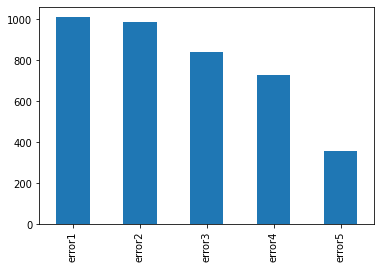

In [15]:
# Some charts
df_err = pd.read_csv('./data/errors.csv')

df_err = df_err.merge(df_machine, on='machineID', how='left')

#fig, ax = plt.subplots(2,2, figsize=(10, 10))

df_err['errorID'].value_counts().plot(kind='bar')

In [16]:
df_err.groupby(['model', 'errorID'])['errorID'].count() 


model   errorID
model1  error1     152
        error2     154
        error3     139
        error4     152
        error5      75
model2  error1     176
        error2     164
        error3     119
        error4     181
        error5      62
model3  error1     352
        error2     346
        error3     317
        error4     193
        error5     120
model4  error1     330
        error2     324
        error3     263
        error4     201
        error5      99
Name: errorID, dtype: int64

In [17]:
# Prepare df_err
df_err = pd.read_csv('./data/errors.csv')

df_err['datetime'] = pd.to_datetime(df_err['datetime'], format='%m/%d/%Y %I:%M:%S %p')
df_err['datetime'] = df_err['datetime'].dt.date
df_err['value'] = 1

df_err = pd.pivot_table(df_err, index=['machineID', 'datetime'], columns=['errorID'], values=['value'], aggfunc=np.sum)
df_err.columns=['errorID_1', 'errorID_2', 'errorID_3', 'errorID_4', 'errorID_5']

df_err.fillna(0, inplace=True)

for col in [ 'errorID_' + str(i+1) for i in range(5)]:
    df_err[col] = df_err[col].astype(int)

df_err

errorID_1  errorID_2  errorID_3  errorID_4  errorID_5
machineID datetime                                                         
1         2015-01-03          1          0          1          0          0
          2015-01-04          0          0          0          0          1
          2015-01-10          0          0          0          1          0
          2015-01-22          0          0          0          1          0
          2015-01-25          0          0          0          1          0
...                         ...        ...        ...        ...        ...
100       2015-11-12          1          0          0          0          0
          2015-11-21          0          1          0          0          0
          2015-12-04          1          0          0          0          0
          2015-12-08          0          1          1          0          0
          2015-12-22          0          0          1          0          0

[3441 rows x 5 columns]

In [19]:
# Import failures data
df_fail = pd.read_csv('./data/failures.csv')

df_fail.head()

,datetime,machineID,failure
0,1/5/2015 6:00:00 AM,1,comp4
1,3/6/2015 6:00:00 AM,1,comp1
2,4/20/2015 6:00:00 AM,1,comp2
3,6/19/2015 6:00:00 AM,1,comp4
4,9/2/2015 6:00:00 AM,1,comp4


In [20]:
# Prepare df_err
df_fail = pd.read_csv('./data/failures.csv', parse_dates=True)

df_fail['datetime'] = pd.to_datetime(df_fail['datetime'], format='%m/%d/%Y %I:%M:%S %p')
df_fail['datetime'] = df_fail['datetime'].dt.date
df_fail['value'] = 1

df_fail = pd.pivot(df_fail, index=['machineID', 'datetime'], columns=['failure'], values=['value'])
df_fail.columns=['fail_comp_1', 'fail_comp_2', 'fail_comp_3', 'fail_comp_4']

df_fail.fillna(0, inplace=True)

for col in [ 'fail_comp_' + str(i+1) for i in range(4)]:
    df_fail[col] = df_fail[col].astype(int)

df_fail.head()

fail_comp_1  fail_comp_2  fail_comp_3  fail_comp_4
machineID datetime                                                      
1         2015-01-05            0            0            0            1
          2015-03-06            1            0            0            0
          2015-04-20            0            1            0            0
          2015-06-19            0            0            0            1
          2015-09-02            0            0            0            1

In [21]:
# Merge dataframes

df = df_agg.merge(df_maint, left_index = True, right_index=True, how='left')
df = df.merge(df_err, left_index = True, right_index=True, how='left')
df = df.merge(df_fail, left_index = True, right_index=True, how='left')

df.fillna(0, inplace=True)

df.reset_index(inplace=True)
df.sort_values(['machineID', 'datetime'], inplace=True)

df

,machineID,datetime,volt_mean,rotate_mean,pressure_mean,vibration_mean,volt_std,rotate_std,pressure_std,vibration_std,maint_comp1,maint_comp2,maint_comp3,maint_comp4,errorID_1,errorID_2,errorID_3,errorID_4,errorID_5,fail_comp_1,fail_comp_2,fail_comp_3,fail_comp_4
0,1,2015-01-01,167.576533,440.515328,98.522345,40.049623,9.300337,49.590263,10.588562,5.739395,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2015-01-02,169.795758,446.832666,98.454608,39.271645,15.742155,38.800266,11.679314,5.579524,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,2015-01-03,171.862244,459.204742,97.998233,48.074091,11.182853,47.387959,8.884765,8.194927,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,2015-01-04,174.792428,448.743201,101.452266,52.190268,19.224657,34.008026,10.807630,5.081258,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1,2015-01-05,171.018408,454.822750,102.363114,43.330311,17.900560,47.803621,10.672868,8.087134,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36595,100,2015-12-28,170.982029,454.875385,97.864404,39.221774,15.030665,58.013495,8.522116,5.384053,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36596,100,2015-12-29,167.114444,459.097599,97.531682,40.117173,16.654803,56.447064,9.257888,4.916935,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36597,100,2015-12-30,168.613777,455.140822,98.415400,39.995452,12.261241,59.849202,9.359740,4.896418,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36598,100,2015-12-31,168.469994,463.241909,101.846119,38.826901,17.310060,67.148361,9.567172,5.670301,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
# Check if maintenance is always true when component fail
for i in range(1, 5):
    print("Comp{} maintenance rate in case of fail: {:.3f}".format(i, df[df['fail_comp_' + str(i)] == 1.0]['maint_comp'  + str(i)].mean()))

Comp1 maintenance rate in case of fail: 0.953
Comp2 maintenance rate in case of fail: 0.988
Comp3 maintenance rate in case of fail: 0.977
Comp4 maintenance rate in case of fail: 0.983


In [23]:
# Add days from last event for error, maintenance and failure

features = [
    'maint_comp1', 'maint_comp2', 'maint_comp3', 'maint_comp4',
    'errorID_1', 'errorID_2', 'errorID_3', 'errorID_4', 'errorID_5',
    'fail_comp_1', 'fail_comp_2', 'fail_comp_3', 'fail_comp_4'
]

df.sort_values(['machineID', 'datetime'], inplace=True)

for f in features:
    group_id = ((df['machineID'] != df['machineID'].shift(1)) | (df[f])).astype(int).cumsum()
    df[f + '_days'] = df.groupby(group_id)[f].cumcount()
    df[f + '_count'] = df.groupby(group_id)[f].rolling(window=3).sum().reset_index(drop=True)
    
df.fillna(0, inplace=True)

df

,machineID,datetime,volt_mean,rotate_mean,pressure_mean,vibration_mean,volt_std,rotate_std,pressure_std,vibration_std,maint_comp1,maint_comp2,maint_comp3,maint_comp4,errorID_1,errorID_2,errorID_3,errorID_4,errorID_5,fail_comp_1,fail_comp_2,fail_comp_3,fail_comp_4,maint_comp1_days,maint_comp1_count,maint_comp2_days,maint_comp2_count,maint_comp3_days,maint_comp3_count,maint_comp4_days,maint_comp4_count,errorID_1_days,errorID_1_count,errorID_2_days,errorID_2_count,errorID_3_days,errorID_3_count,errorID_4_days,errorID_4_count,errorID_5_days,errorID_5_count,fail_comp_1_days,fail_comp_1_count,fail_comp_2_days,fail_comp_2_count,fail_comp_3_days,fail_comp_3_count,fail_comp_4_days,fail_comp_4_count
0,1,2015-01-01,167.576533,440.515328,98.522345,40.049623,9.300337,49.590263,10.588562,5.739395,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
1,1,2015-01-02,169.795758,446.832666,98.454608,39.271645,15.742155,38.800266,11.679314,5.579524,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,1,0.0,1,0.0,1,0.0,1,0.0,1,0.0,1,0.0,1,0.0,1,0.0,1,0.0,1,0.0,1,0.0,1,0.0
2,1,2015-01-03,171.862244,459.204742,97.998233,48.074091,11.182853,47.387959,8.884765,8.194927,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0.0,2,0.0,2,0.0,2,0.0,0,0.0,2,0.0,0,0.0,2,0.0,2,0.0,2,0.0,2,0.0,2,0.0,2,0.0
3,1,2015-01-04,174.792428,448.743201,101.452266,52.190268,19.224657,34.008026,10.807630,5.081258,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3,0.0,3,0.0,3,0.0,3,0.0,1,0.0,3,0.0,1,0.0,3,0.0,0,0.0,3,0.0,3,0.0,3,0.0,3,0.0
4,1,2015-01-05,171.018408,454.822750,102.363114,43.330311,17.900560,47.803621,10.672868,8.087134,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0.0,4,0.0,4,0.0,0,0.0,2,1.0,4,0.0,2,1.0,4,0.0,1,0.0,4,0.0,4,0.0,4,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36595,100,2015-12-28,170.982029,454.875385,97.864404,39.221774,15.030665,58.013495,8.522116,5.384053,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,79,0.0,4,0.0,79,0.0,49,0.0,24,0.0,20,0.0,6,0.0,120,0.0,245,0.0,109,0.0,19,0.0,361,0.0,361,0.0
36596,100,2015-12-29,167.114444,459.097599,97.531682,40.117173,16.654803,56.447064,9.257888,4.916935,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,80,0.0,5,0.0,80,0.0,50,0.0,25,0.0,21,0.0,7,0.0,121,0.0,246,0.0,110,0.0,20,0.0,362,0.0,362,0.0
36597,100,2015-12-30,168.613777,455.140822,98.415400,39.995452,12.261241,59.849202,9.359740,4.896418,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,81,0.0,6,0.0,81,0.0,51,0.0,26,0.0,22,0.0,8,0.0,122,0.0,247,0.0,111,0.0,21,0.0,363,0.0,363,0.0
36598,100,2015-12-31,168.469994,463.241909,101.846119,38.826901,17.310060,67.148361,9.567172,5.670301,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,82,0.0,7,0.0,82,0.0,52,0.0,27,0.0,23,0.0,9,0.0,123,0.0,248,0.0,112,0.0,22,0.0,364,0.0,364,0.0


In [24]:
# Export data mart
df.to_csv('./data/_data_mart.csv')

In [25]:
# Select boundary data for train/test split
date_split = pd.Timestamp("2015-09-01")

print("Train split size: {:.2f}%".format(100*(df.datetime < date_split).astype(int).mean()))
print("Test  split size: {:.2f}%".format(100*(df.datetime >= date_split).astype(int).mean()))


Train split size: 66.39%
Test  split size: 33.61%


c:\users\denny\appdata\local\programs\python\python39\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


In [26]:
# Model

features = [
    'volt_mean', 'volt_std', 
    'rotate_mean', 'rotate_std',
    'pressure_mean', 'pressure_std',
    'vibration_mean', 'vibration_std',
    'maint_comp1_days', 'maint_comp2_days', 'maint_comp3_days', 'maint_comp4_days',
    'errorID_1_days', 'errorID_2_days', 'errorID_3_days', 'errorID_4_days', 'errorID_5_days', 
    'errorID_1_count', 'errorID_2_count', 'errorID_3_count', 'errorID_4_count', 'errorID_5_count', 
    'fail_comp_1_days', 'fail_comp_2_days', 'fail_comp_3_days', 'fail_comp_4_days'
]

X = df[features]

date_split = pd.Timestamp("2015-09-01")

train_idx = df.datetime < date_split 
test_idx = df.datetime >= date_split 

X_train = X[train_idx]
X_test = X[test_idx]

GridSearchCV_results = []

for i in range(1, 5):
    y = (df['fail_comp_' + str(i)].shift(-1) == 1) & (df['machineID'] == df['machineID'].shift(-1)) # Failure next day
    y = y.astype(int)

    y_train = y[train_idx]
    y_test = y[test_idx]

    parameters = {
        'max_depth': [3, 4, 5],
        'n_estimators': [10, 25, 50, 100]
    }
    model = GridSearchCV(XGBClassifier(eval_metric='logloss', use_label_encoder=False), parameters)
    
    model.fit(X_train, y_train)
    
    GridSearchCV_results.append(model)
    
    print("Model evaluation for comp{} failure:".format(i))
    print(classification_report(y_test, model.predict(X_test)))
    
    print("\n")

Model evaluation for comp1 failure:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12249
           1       0.96      0.96      0.96        51

    accuracy                           1.00     12300
   macro avg       0.98      0.98      0.98     12300
weighted avg       1.00      1.00      1.00     12300



Model evaluation for comp2 failure:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12210
           1       1.00      0.99      0.99        90

    accuracy                           1.00     12300
   macro avg       1.00      0.99      1.00     12300
weighted avg       1.00      1.00      1.00     12300



Model evaluation for comp3 failure:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12260
           1       0.94      0.78      0.85        40

    accuracy                           1.00     12300
   macro avg    